# Fundamentos de Machine Learning
# Proyecto de Aplicación 1: Regresión

**Objetivos**
* Aplicar técnicas de regresión para construir un modelo predictivo que permita estimar la demanda sobre el uso de un sistema de alquiler de bicicletas siguiendo el ciclo de machine learning.
* Determinar cuáles son los factores que más inciden en la demanda con base en los datos.

**Conjunto de datos**

El conjunto de datos recoge información sobre la cantidad de bicicletas rentadas en un período de tiempo, junto con información meteorológica y de temporalidad, entre otros.


**Actividades**
1. Eploración y perfilamiento de los datos, empleando funcionalidades de la librería pandas.

2. Limpieza y preparación de los datos, justificando las decisiones tomadas con base en los resultados de la fase de exploración.

3. Construcción de un modelo de regresión polinomial.  Para determinar el grado de la transformación polinomial se recomienda emplear técnicas de selección de modelos sobre los valores de polinomio [2,3]. Emplee la métrica RMSE.

4. Construcción de un modelo de regresión regularizada Lasso. Para determinar el valor del hiperparámetro de regularización, emplee técnicas de selección de modelos sobre los siguientes valores [1,2,3,4,5] y emplee la métrica RMSE.

5. Elaboración de una tabla comparativa mostrando el rendimiento sobre test de los dos modelos seleccionados (con mejores rendimientos) de las actividades 3 y 4, con las métricas R2, RMSE y MAE.

6. Con base en el modelo Lasso determinar las variables más importantes para la predicción.

**Consideraciones:**
* Emplee el valor de semilla de 77 (random_state).
* En las técnicas de selección de modelos uno de los parámetros que debes indicar es `scoring = 'neg_root_mean_squared_error'`, con el fin de seleccionar RMSE como métrica de evaluación en la búsqueda.

# **1.Importación de datos y dependencias**

### 1.1. Dependencias

##### 1.1.1. Librerías principales

In [1]:
# Importar librerías

import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# Modelamiento

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import BaggingRegressor

##### 1.1.2. Utilidades

In [2]:
def excel_to_csv(path, sheet_name):
  df_excel = pd.read_excel(path, sheet_name=sheet_name)
  columnas = df_excel.columns.tolist()[0].split(',')
  data_dict = {columna: [] for columna in columnas}
  for registro in df_excel.iloc[1:].values:
    registro = registro[0]
    valores = registro.split(',')
    for i, columna in enumerate(columnas):
      data_dict[columna].append(valores[i])
  data_raw = pd.DataFrame(data_dict)
  return data_raw


def trasnformar_tipo_datos(data, tipos_de_datos):
  df = data.copy()
  for columna, tipo in tipos_de_datos.items():
    df[columna] = df[columna].astype(tipo)
  return df

In [3]:
def histogram_box(dataframe, variable):
  df = dataframe
  fig, ax = plt.subplots(1,2,figsize=(14,5))
  sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
  sns.boxplot(data=df, x=str(variable))

  mean = df[str(variable)].mean()
  ax[0].axvline(mean, color='red')

  variance = round(df[str(variable)].var(),2)
  kurtosis = round(df[str(variable)].kurt(),2)
  skewness = round(df[str(variable)].skew(),2)

  textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
  ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
  ax[0].set_title(f'Histogram of {variable}')
  ax[0].set_xlabel(f'{variable}')
  ax[0].set_ylabel("Frecuency")
  ax[0].grid(True)
  ax[1].set_title(f'Boxplot of {variable}')
  ax[1].set_xlabel(f'{variable}')
  ax[1].set_ylabel("Frecuencias")
  ax[1].grid(True)

  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [4]:
class data_processing:
  def __init__(self):
    pass

  def null_classifier(self,dataframe):
    series = dataframe.isnull().sum() * 100 / dataframe.shape[0]
    nulls  = {'Variable': series.index, 'Percentage of null values': series.values}
    nulls = pd.DataFrame(nulls).sort_values(by = 'Percentage of null values', ascending = False)
    return nulls

  def column_selector(self, dataframe, column_names):
    df = dataframe
    selected_columns = [col for col in column_names if col in df.columns]
    selected_df = df[selected_columns]
    return selected_df

  def null_df_filter(self, dataframe, threshold):
    df = dataframe
    nulls = self.null_classifier(df)
    filtered = nulls[nulls['Percentage of null values'] < threshold]['Variable']
    df_filtered = df[filtered]
    return df_filtered

### 1.3. Importación y descripción de los datos

---
Importación y descripción de los datos

---
Los sistemas de bicicletas compartidas son una innovación en alquileres de bicicletas, donde todo el proceso es automático. Actualmente, hay más de 500 programas de bicicletas compartidas en el mundo, con más de 500 mil bicicletas. Estos sistemas son importantes para el tráfico, el medio ambiente y la salud. Además, los datos generados por estos sistemas son útiles para la investigación, ya que registran la duración del viaje y las posiciones de inicio y fin, convirtiéndolos en una red de sensores virtual para detectar la movilidad en la ciudad y eventos importantes.

El diccionario de los datos es el siguiente:

|Variable|Descripción|Tipología|
|---|---|---|
|season| Estación del año (Winter, Spring, Summer, Fall)|categórica|
|weekday|Día de la semana (de 1 a 7)|numérico|
|weathersit|Clima (Clear, Mist, Light Rain, Heavy Rain)|categórica|
|temp|Temperatura|numérico|
|atemp|Sensación de temperatura|numérico|
|hum|Humedad|numérico|
|windspeed|Velocidad del viento|numérico|
|cnt|Cantidad de bicicletas rentadas|numérico|
|time_of_day|Parte del día (Morning, Evening, Night)|categórica|


In [5]:
import os
print(os.getcwd())

/content


In [6]:
cd ..

/


In [7]:
from google.colab import files
uploaded = files.upload()

# Then you can read the file like this:
df = pd.read_csv(list(uploaded.keys())[0])

Saving day.csv to day.csv


In [8]:
df = pd.read_csv("day.csv")

In [9]:
print(df.iloc[1].tolist())

[2, '2011-01-02', 1, 0, 1, 0, 0, 0, 2, 0.363478, 0.353739, 0.696087, 0.248539, 131, 670, 801]


Como podemos observar, exíste una primera compliación con los datos. El formato en el que vienen almacenados corresponde a un archivo tipo Excel que al importarlo por métodos tradicionales en Pandas, genera un dataframe de 17379 regístros y una columna, lo cual significa que todos los datos de todas las columnas están siendo apiladas en una sola columna.

Por otra parte, como se muéstra en la celda anterior, cada regístro crudo está presentado en el dataset como una lísta de un único elemento de tipo string. Así, para poder procesar nuestros datos tenemos que:
1. Tomar el primer regístro como los headers de las columnas.
2. Tomar cada regístro del archivo excel, extrare el único elemento y dividir el string mediante el método `.split(',')` de modo que se genere una lísta con todos los valores correspondientes a cada columna para el regístro en cuestion.
3. Crear un diccionario vacío cuyas llaves sean los nombres de las columnas.
4. Generar un iterador que rellene los valores de los diccionarios para cada columna y recorra todos los regístros del dataset.
5. Reconstruir el dataset como un DataFrame.

Éstos procedimientos son llevados a cabo por la función `excel_to_csv` presente en la sección de utilidades 1.1.2. del presente notebook.

Una vez importados los datos, procedamos a realizar exploraciones básicas de los mísmos tales como la verificación del tipo de datos que poseemos, el tamaño del dataset y las estadísticas descriptivas básicas de cada variable para tener una perspectiva inicial de la información que disponemos.

In [10]:
df.shape

(731, 16)

Descripción de las variables del dataset.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Como vemos, todos los datos están en formato string, así pues, tenemos que transformar el tipo de datos para cada columna. Para ello, empleamos la función transformar_tipo_datos presente en la sección de utilidades 1.1.2. del presente notebook.

In [12]:
tipos = {
    'temp': float,
    'atemp':float,
    'hum':float,
    'windspeed':float,
    'cnt': int,
}

df = trasnformar_tipo_datos(df, tipos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


# **2.Análisis Exploratorio de Datos  (EDA)**

### 2.1. Derección de valores nulos y duplicados

---
Detección de valores nulos y duplicados

---


Una vez los datos han quedado en el formato estructurado adecuado, procedemos a explorar los datos mediante visualizaciones y estadísticos principales. Para empezar, observemos la estadística descriptiva básica de nuestros datos numéricos y categóricos.

In [13]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


De los estadísticos principales podemos observar:
* En promedio, se alquila una cantidad de 189 bicicletas en el periodo de tiempo sobre el cuál los datos fueron recogidos.
* En promedio, los alquileres se realizan el cuarto día de la semana (jueves).
* El 25% de los alquileres suceden el segundo dia de la semana (martes), el 50% en el cuarto (jueves), el 75% en el sexto (sabado).
* El 25% del total de alquileres corresponde a 40, el 50% de los alquileres corresponde a 142 mientras que el 75% del total de los alquileres corresponde a 281.


Notamos por otra parte que los valores de la variable `weekday` van desde 0 a 6, información que no es consistente con el diccionario de los datos en el cual se estipula que los días van desde 1 a 7. Para mantener la congruencia entre éstos dos objetos, datos y diccionario, realizamos una transformación numérica sobre los datos de la siguiente manera.

In [14]:
df['weekday'] = df['weekday'] + 1
df['weekday'].unique()

array([7, 1, 2, 3, 4, 5, 6])

Note entonces, ya que en el diccionario de los datos no se especifica la convención correcta entre el indice y el día de la semana, procedemos a usar la siguiente convención: `domingo:7` , `lunes:1`, `martes:2`, `miercoles:3`, `jueves:4`, `viernes:5`, `sábado:6`.

In [15]:
df.describe(include='object')

,dteday
count,731
unique,731
top,2011-01-01
freq,1


Según la frecuencia de las variables categóricas, se observa que:
* El verano (summer) es la temporada anual en donde más se rentan bicicletas.
* El tipo de clima preferido por las personas para tomar paseos en bicicleta es 'Clear'.
* El horario del día donde las personas toman más paseos en bicicleta es la noche.

No obstante, ¿estas observaciones iniciales son acertadas?. Para contestar esta pregunta, tenemos que determinar si dentro del dataset existen valores nulos por columna para descartar la posibilidad de que nuestras observaciones estén sesgadas debido a la presencia de valores nulos.

In [16]:
df.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0


Ahora, procedemos a responder la pregunta ¿exíste un número importante de duplicados?

In [17]:
n_duplicados = df.duplicated().sum()
porcentaje_duplicados = (n_duplicados / df.shape[0]) *100
print('El número de duplicados es = ', n_duplicados)
print('Porcentaje de duplicados es =', porcentaje_duplicados)

El número de duplicados es =  0
Porcentaje de duplicados es = 0.0


Ya que el número de duplicados solo corresponde al 0.241% de los datos, las distribuciones no se deben ver fuertemente afectadas por su presencia, por ende, continuaremos el análisis exploratorio de los datos eliminando dichos suplicados sin temor a causar estragos en las distribuciones de los datos.

In [18]:
df.drop_duplicates(inplace=True)
n_duplicados = df.duplicated().sum()
porcentaje_duplicados = (n_duplicados / df.shape[0]) *100
print('El número de duplicados es = ', n_duplicados)
print('Porcentaje de duplicados es =', porcentaje_duplicados)

El número de duplicados es =  0
Porcentaje de duplicados es = 0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### 2.2. Análisis univariado de variables numéricas

Ya que no exísten valores nulos en nuestras variables, procedemos con el análisis univariado de nuestro dataset. Para empezar, observemos las distribuciones de las variables numéricas contínuas y para la variable `'cnt'` e intentemos detectar posibles valores atípicos o outliers. Para ésto, emplearemos una visualización de histograma y boxplot mediante la función `histogram_box`, presente en la sección de utilidades 1.1.2. del presente notebook.

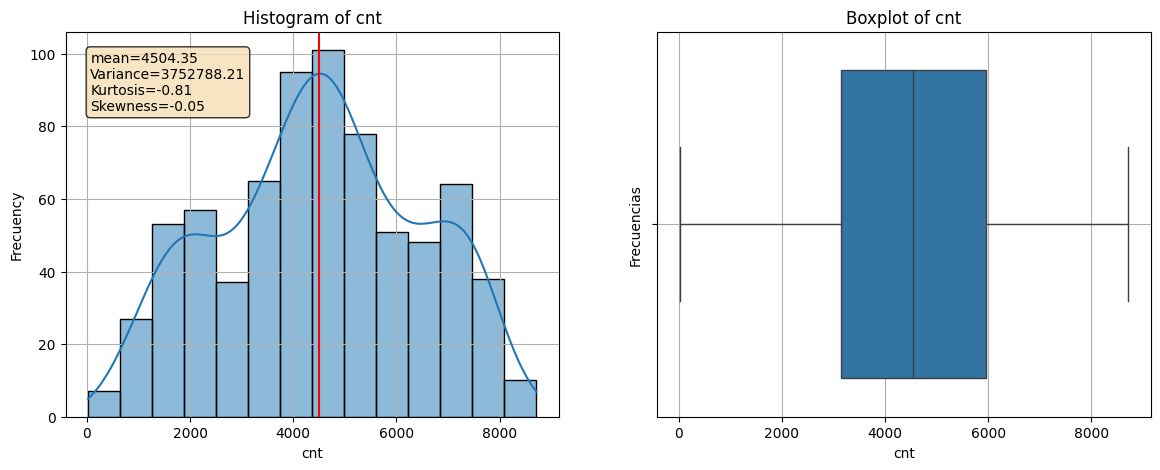

In [20]:
histogram_box(df, 'cnt')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El número de alquileres de bicicletas presenta una distribución de sus datos casi monotónicamente decreciente con respecto al número de alquileres, lo cual quiere decir que exíste una gran cantidad de personas que realiza pocos alquileres de biscicletas y una pequeña cantidad de personas que realiza una alta cantidad de alquileres. Por ende, la distribución de los datos posee una alta varianza y un sesgo (skewness) positivo. Lo que implica una distribución asimétrica.

* La gran mayoria de las personas realiza un número de alquileres entre 40 y 281. No obstante, exísten unos valores atípicos que corresponden a un selecto número de personas que realiza más de 650 alquileres.

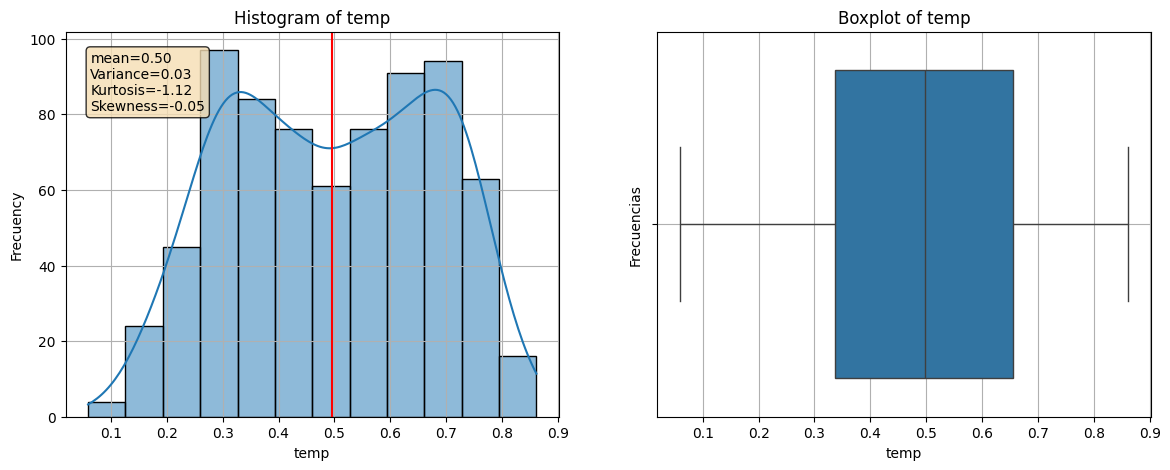

In [21]:
histogram_box(df, 'temp')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del alguiler de bicicletas con respecto a la temperatura tiende a ser bimodal. Esto quiere decir que las personas prefieren realizr alquileres de bicicletas especialmente en dos valores de temperatura.

* Las personas prefieren alquilar bicicletas en promedio, cuando hace una temperatura de 15.36 grados.

* La distribución del alquiler de bicicletas con respecto a la temperatura es prácticamente simétrica lo que se traduce en un skewness cercano a cero. No se puede decir que la distribución tenga una fuerte presencia de "colas" y la mayoría de los datos se encuentra concentrados en un amplio rango ya que su kurtosis es menor a 3, por ende, es una distribuciínplaticúrtica.

* Con respecto a la temperatura, no exísten valores atípicos, por ende, los datos se encuentran altamente concentrados entre 7.9 y 23 grados.

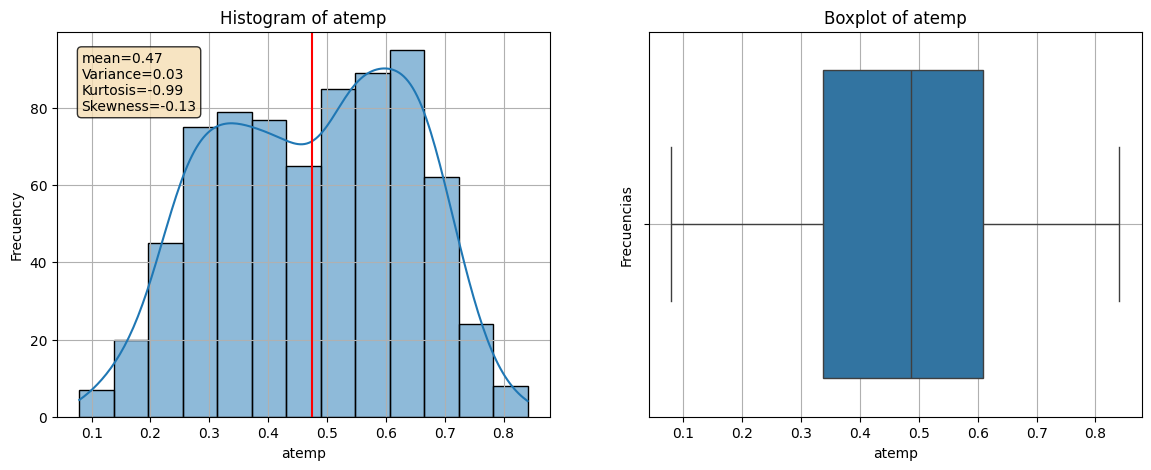

In [22]:
histogram_box(df, 'atemp')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del número de alquileres con respecto a la sensacion de la temperatura es demasiado similar a la de la temperatura, a diferencia de que en éste caso la variable tiende a tener más modas.

* En promedio, las presonas prefieren alquilar bicicletas cuando exíste una sensación térmica cercana a 15.40 grados.

* La distribución es prácticamente simétrica, sin presencia fuerte de colas y sin presencia de valores atípicos.

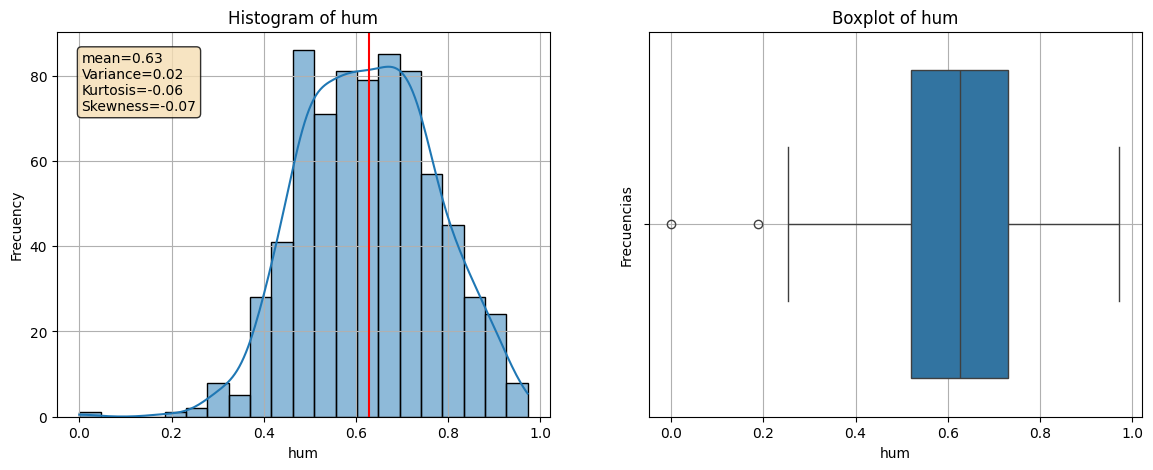

In [23]:
histogram_box(df, 'hum')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El alquiler de bicicletas ocurre en promedio para humedades moderadas de 0.6.
* La distribución de los alquileres en función de la humedad posee sesgo hacia la izquierda presentando sesgo negativo. Específicamente, la mayoría de los alquileres ocurre en un ampluio rango al rededor del valor de humedad 0.6  que va aproximadamente desde 0.4 hasta 0.9.
* Exíste un alto número de alguileres entre el valor de humedad 0.8 y 0.9.
* Corresponde a una distribución platicúrtica.
* Exíste un pequeño número de valores atípicos los cuales corresponden a alquileres hechos a muy bajas humedades.

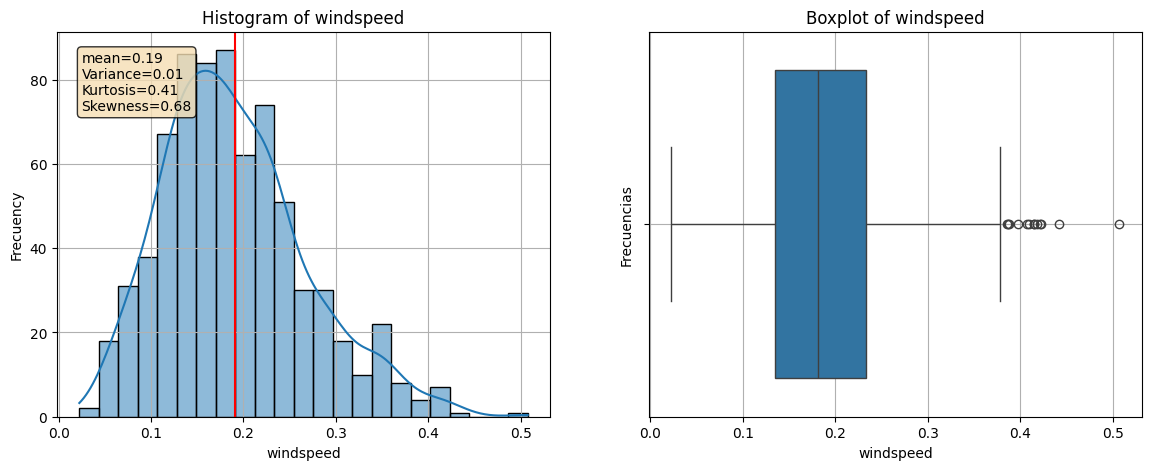

In [24]:
histogram_box(df, 'windspeed')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del número de alquileres en función de la velocidad del viento es ligeramente asimétrica hacia la derecha, presentando sesgo positivo.

* En promedio, los alquileres de bicicletas ocurren cuando exíste una velocidad del viento de 12.74.

* Existe una presencia de valores atípicos los cuales corresponden a alquileres hechos a altas velocidades del viento.

### 2.3. Análisis de variables categóricas

Una vez analizadas las variables numéricas no ordinales y contínuas, procedamos a analizar que ocurre con las variables categóricas y ordinales.

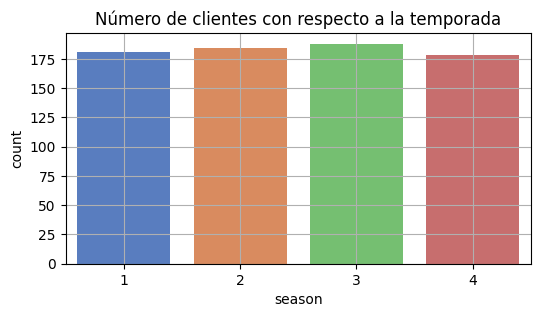

In [25]:
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='season', palette = 'muted')
plt.title('Número de clientes con respecto a la temporada')
plt.grid()
plt.show()

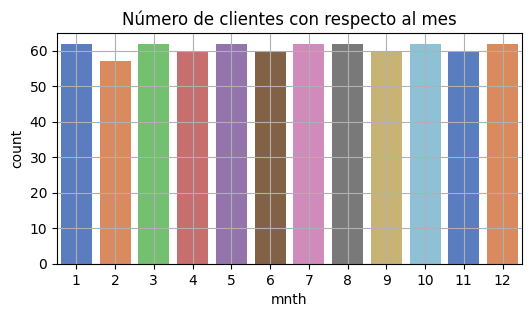

In [26]:
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='mnth',palette = 'muted')
plt.title('Número de clientes con respecto al mes')
plt.grid(True)
plt.show()

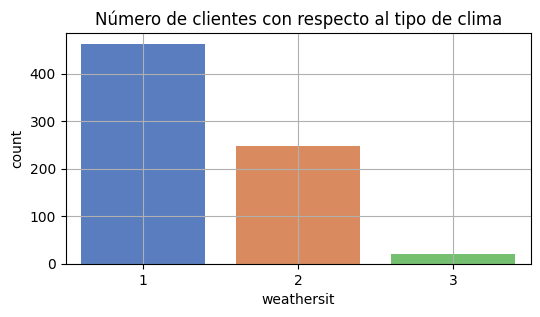

In [27]:
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='weathersit',palette = 'muted')
plt.title('Número de clientes con respecto al tipo de clima')
plt.grid(True)
plt.show()

Con respecto a los plots de conteo anteriores, con respecto al número de regístros de alquiler podémos concluir lo siguiente:
* La mayoría de regístros ocurren en verano.

* El tipo de clima es muy relevante, la mayoría de alquileres ocurre en clima despejado.

* No exíste una pronunciada jerarquía entre los días de la semana, no obstante, con respecto al conteo de alquileres, la mayoría de éstos ocurre en el día 7 y 1.

* La mayoría de regístros reportados según el periodo del día ocurren en la noche.

A pesar de que el número de regístros ocurridos de acuerdo a una categoría nos da indicios a cerca del comportamiento de la renta de bicicletas con respecto a cierta variable, no nos da ninguna información a cerca de **cómo se comporta el número de alquileres efectuado por una persona en función de la categoría**.

Para obtener información en éste aspecto, procedemos a realizar comparaciones entre el número de alquileres efectuados por una persona (no el número de regístros) y variables como el día de la semana, el tiempo del día, el tipo de clima y la temporada.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


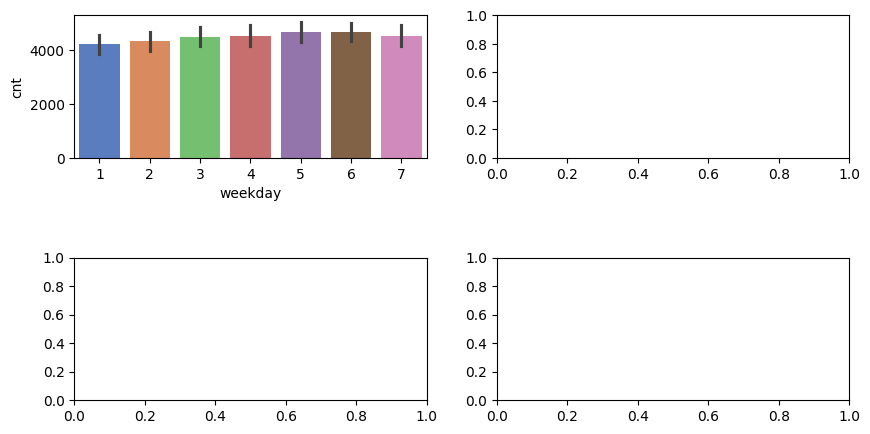

In [29]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
sns.barplot(data=df, x="weekday", y="cnt", ax=ax[0,0],palette = 'muted')

plt.subplots_adjust(hspace=0.7)
plt.show()

A partir de la comparación entre el número de alquileres y variables tales como el día de la semana y periodo del día podemos observar que:

* No exíste una pronunciada jerarquía entre los días de la semana con respecto al número de alquileres por persona. No obstante, es el día 5 y 6 aquellos en donde más alquileres ocurren.

* Durante todos los días de la semana, exíste un alto número de personas que han realizado un alto número de alquileres. Es decir, el día de la semana no parece influir en la presencia de outliers (personas que rentan bicicletas con alta frecuencia).

* El periodo del día donde más personas con alta frecuencia de alquiler de bicicletas ocurren es en la tarde, luego en la mañana y por último, la noche. Es decir, a pesar de que según el periodo del día, la mayoría de regístros ocurren en la noche, las personas que alquilan bicicletas en la noche suelen alquilar bicicletas muy poco frecuente, mientras que las personas que alquílan bicicletas en la tarde, suelen ser personas que frecuentemente alquilan bicicletas.

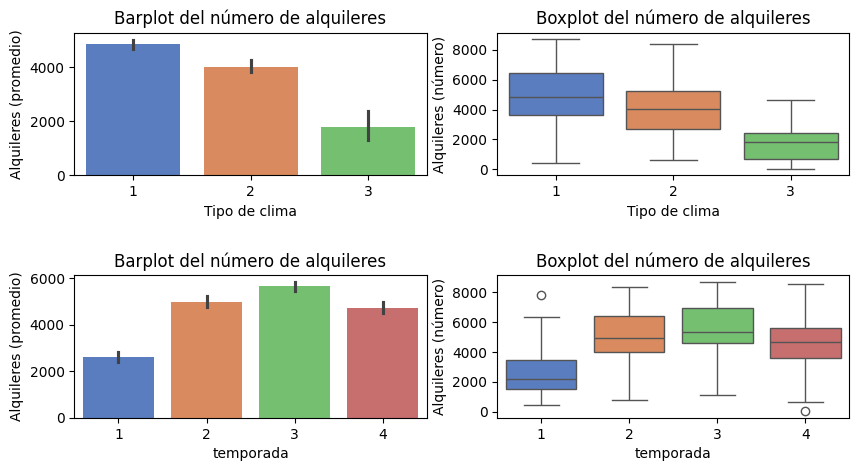

In [30]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
sns.barplot(data=df, x='weathersit', y="cnt", ax=ax[0,0],palette = 'muted')
sns.boxplot(data=df, x='weathersit', y="cnt", ax=ax[0,1],palette = 'muted')
sns.barplot(data=df, x='season', y="cnt", ax=ax[1,0],palette = 'muted')
sns.boxplot(data=df, x="season", y="cnt", ax=ax[1,1],palette = 'muted')

ax[0,0].set_title("Barplot del número de alquileres")
ax[0,0].set_xlabel("Tipo de clima")
ax[0,0].set_ylabel("Alquileres (promedio)")
ax[0,1].set_title("Boxplot del número de alquileres")
ax[0,1].set_xlabel("Tipo de clima")
ax[0,1].set_ylabel("Alquileres (número)")
ax[1,0].set_title("Barplot del número de alquileres")
ax[1,0].set_xlabel("temporada")
ax[1,0].set_ylabel("Alquileres (promedio)")
ax[1,1].set_title("Boxplot del número de alquileres")
ax[1,1].set_xlabel("temporada")
ax[1,1].set_ylabel("Alquileres (número)")

plt.subplots_adjust(hspace=0.7)
plt.show()

A partir de la comparación entre el número de alquileres y variables tales como el tipo de clima y la temporada podemos observar que:

* Exíste una correspondencia entre el número de alquileres y la temporada, en donde más ocurren alquileres es en verano, primavera, otoño y por último invierno.

* La temporada que más presenta valores atípicos, es decir, un alto número de alquileres efectuados por un pequeño grupo de personas, es en invierno.

* Exíste una fuerte correspondencia entre el tipo de clima y el número de alquileres, en donde el clima favorito por las personas para tomar paseos en bicicleta es despejado, luego con neblina, lluvioso suave y por último, lluvioso.

* En general, el número de regístros ocurridos en determinada temporada se corresponde con la jerarquía existente entre el número de alquileres por persona en determinada temporada. Así, la mayoría de de clientes alquila en verano y a quellos que alquilan bicicletas suelen tener una alta frecuencia de alquiler.

* En general, el número de regístros en determinado tipo de clima se corresponde con la jerarquía existente entre el número de alquileres por persona en determinado tiempo del día. De ésta manera, la mayoría de clientes que alquila en clima despejado son aquelos que alquilan bicicletas frecuentemente.

### 2.4. Análisis bivariado y de correlación

Gracias a que nuestro dataset posee solo 9 variables, es posible realizar una mayor cantidad de comparaciones entre variables sin perder fácilmente el control ni el enfoque del análisis exploratorio. En la presente sección exploraremos los datos en búsqueda de patrones de relación directa entre pares de variables bien sea en forma de correlación (linealidad) o, patrones no lineales como clusters.

Para empezar, realicemos un pairplot tipo scatter donde vamos a tomar como el criterio de agrupación de datos (etiquetado) las variables más importantes con base a su relación con el número de clientes o alquileres efectuados: la temporada y el tipo de clima.

In [31]:
plt.figure(figsize=(10,10))
sns.pairplot(data=df, hue='season', kind='scatter')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

A partir de la observación del pairplot anterior, podemos hacernos una perspectiva general de como los posibles pares de variables expresan patrones dentro de los datos. Podemos observar lo siguiente:
* Ningún scatter plot entre variables refleja una relación lineal o de correlación entre sí a escepción de las variables 'temperatura' y 'sensación térmica', lo cuál es natural debido a que éstas dos variables están estrechamente relacionadas y son dependientes entre sí.

* Con base al pairplot cuya variable de etiquetado es la temporada, es posible evidenciar patrones tipo cluster, es decir, éste etiquetado permite descubrir que los datos se agrupan y se evidencian cumulos.
  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el invierno constituyen clientes que alquilan de manera menos frecuente. Éstos clientes de baja frecuencia alquilan en temperaturas bajas.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el otoño constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta. Éstos clientes alquilan en temperaturas intermedias.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el verano constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta. Éstos clientes alquilan en temperaturas altas.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la primavera no exiben un patron visualmente perceptible, aparentemente se encuentran a frecuencias de alquiler y temperaturas altas.

  * De manera general con respecto a la temporada, es posible ver que esta variable estrecha el rango de frecuencia de alquiler de los clientes.

  * A partir de la relación `cnt-windspeed`, no es muy claro el patrón de los datos, sin embargo puede insinuarse que a medida que la temporada cambia, la frecuencia de alquiler de los clientes también cambia, donde el invierno refleja los clientes de baja frecuencia, el otoño aquellos de frecuencia intermedia-alta, mientras que el verano y la primavera parecen reflejar clientes desde baja a alta frecuencia.

* La relación `hum-temp` ilustra que en general, para las temporadas de invierno, otoño y verano, los alquileres ocurren dentro de un rango de humedad que va desde la humedad baja hasta la alta. Por otra parte los clientes que alquilan en primavera suelen hacerlo en un rango de temperatura amplio  pero éstos clientes alquilan en valores de humedad bajos.

In [32]:
plt.figure(figsize=(10,10))
sns.pairplot(data=df, hue='weathersit', kind='scatter')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

A partir del pairplot anterior, es difícil extrar comportamientos o patrones, no obstante la predominancia del color azul deja en evidencia que es en el clima despejado en donde más clientes alquilan bicicletas.

Del anterior pairplot no es posible extraer fácilmente los patrones implicitos en los datos con respecto al tiempo del dia. No obstante puede señalarse lo siguiente:

* A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente entorno a temperaturas medias y altas.

* A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la mañana constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente entorno a temperaturas medias.

* A partir de la relación `cnt-hum`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente a humedades bajas.

* A partir de la relación `cnt-hum`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente a humedades altas.

Para evidenciar cuantitativamente la falta de correlación o colinealidad entre las variables, veremos a continuación que las únicas variables que presentan correlación son la temperatura y la sensación térmica de la temperatura. Por otro lado todas las demás variables poseen un coeficiente de correlación prácticamente nulo. No obstante note que las variables de temperatura, sensación térmica y cantidad de  alquiler por cliente (`'cnt'`) tienen una leve correlación, lo cual insinúa una vez más la relación entre los factores del clima y la propension a alquilar bicicletas.

Finalmente, realizaremos un scatter plot que ayude a relacionar múltiples variables relacionadas con el clima tales como la temperatura, la temporada, el tipo de clima y el periodo del dia.

No obstante debido a la complejidad de los datos, solo puede concluirse que se evidencia una predominancia de clientes para el clima despejado, donde entre mayor sensación térmica máyor es la presencia de clientes de alta frecuencia.

### 2.5. Análisis multivariado

<Figure size 400x300 with 0 Axes>

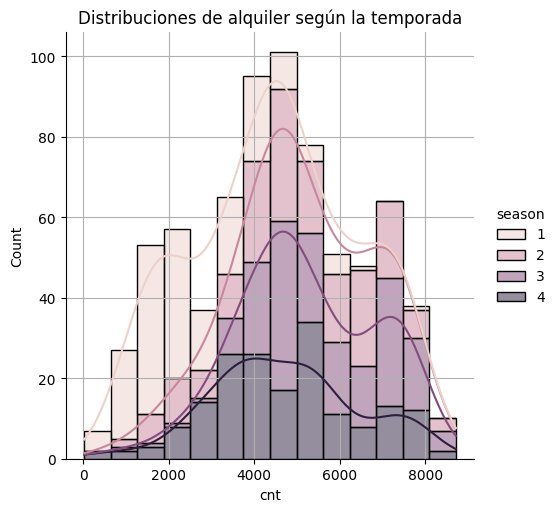

In [33]:
plt.figure(figsize=(4,3))
sns.displot(data=df,x='cnt',hue='season',
            stat='count',multiple='stack',kde=True)
plt.title('Distribuciones de alquiler según la temporada')
plt.grid(True)
plt.show()

In [34]:
df['season'].value_counts()

,count
season,
3,188
2,184
1,181
4,178


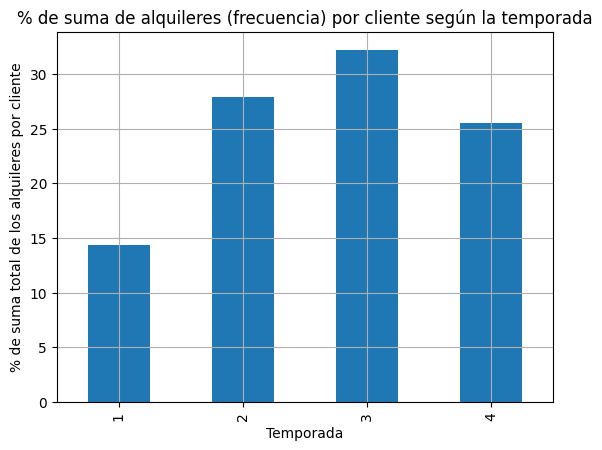

In [35]:
grupos_temporada = df.groupby('season')['cnt'].sum()
porcentaje_temporada =(grupos_temporada / grupos_temporada.values.sum()) *100
porcentaje_temporada.plot(kind='bar')
plt.title('% de suma de alquileres (frecuencia) por cliente según la temporada')
plt.grid(True)
plt.xlabel('Temporada')
plt.ylabel('% de suma total de los alquileres por cliente')
plt.show()

Finalmente, si estudiamos la cantidad de regístros y el número total de alquileres por periodo del día, concluimos:

* El periodo del día es importante en la cantidad de alquileres, puede ser tanto por la calidez del día como por cuestiones como la cantidad de movimiento de la ciudad. Se evidencia que entre la jerarquía de las distribuciones corresponde a noche, mañana y tarde. Donde la distribución se ubica más hacia la derecha a medida que lso regístros se acumulan más en la región de frecuencias de alquiler altas, note entonces que ésto evidencia que la tarde es el periodo del día donde más alquileres ocurren y clientes de mayor frecuencia tienen lugar, mientras que la noche es el periodo donde los clientes de baja frecuencia tienen lugar.

* Para complementar lo anterior, observe que la suma de todos los alquileres efectuados por periodo del día es mayor para la tarde, seguido por la mañana y luego por la noche, lo que convierte a la noche en el periodo de menor cantidad de alquileres hechos en la ciudad.

<Figure size 400x300 with 0 Axes>

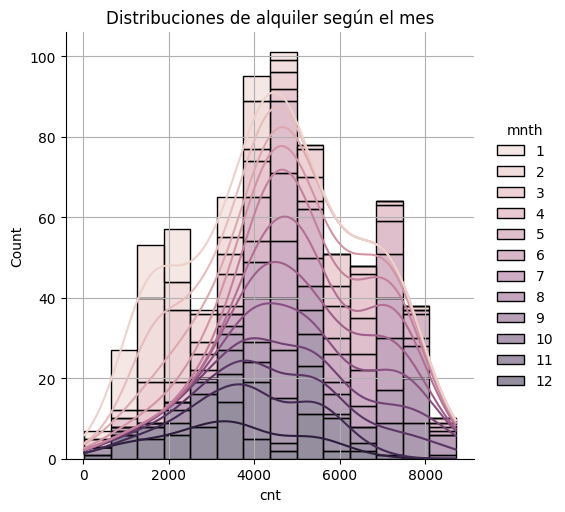

In [36]:
plt.figure(figsize=(4,3))
sns.displot(data=df,x='cnt',hue='mnth',
            stat='count',multiple='stack',kde=True)
plt.title('Distribuciones de alquiler según el mes')
plt.grid(True)
plt.show()

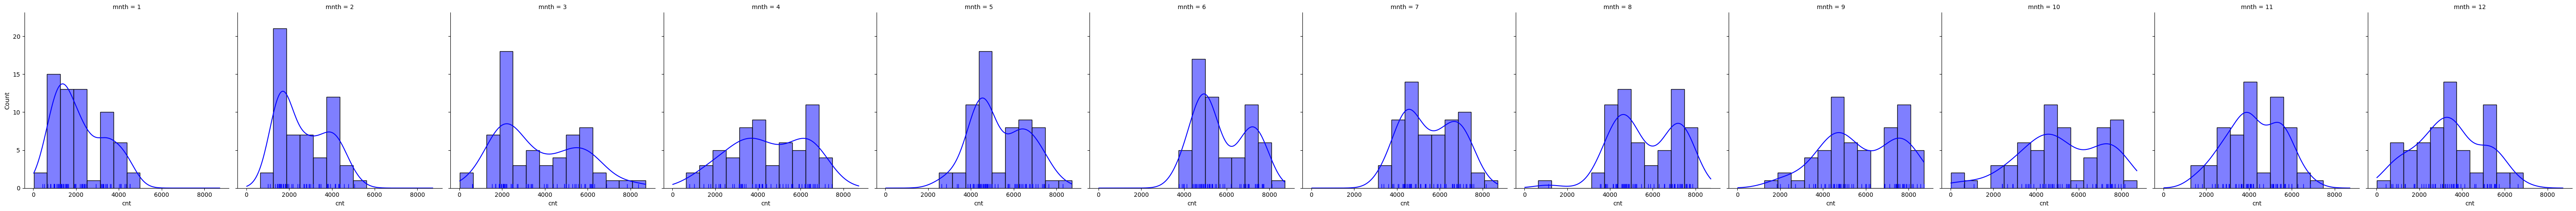

In [37]:
sns.displot(data=df, x='cnt',
            kde=True,
            color='blue', rug=True,
            col='mnth')
plt.show()

# **3.Modelamiento de los datos**

### 3.1. Preparación de los datos

---
Preparación de los datos

---

La presente subsección, desarrolla los diferentes métodos de preprocesamiento de los datos cuyos procedimientos están destinados a preparar los datos para la fase de modelamiento. Dentro de los temas a tratar aquí, hablaremos de las modificaciones y transformaciones efectuadas a los datos con base a las conclusiones desarrolladas en la fase EDA y al conocimiento del contexto del problema.

Dentro de la presente sección, encapsularemos todos los procedimientos necesarios en constructores o clases que permitan de manera modular, usar todo un conjunto de funciones de preprocesamiento con el fín de modularizar las partes del código. En general, los procesos a efectuar dentro de la presente subsección son:

1. Eliminación de duplicados.
2. Escalamiento de los datos.
3. Creación de características polinómicas.

Antes de empezar, realicemos una copia del dataframe y asegurémonos de que no existan duplicados.

In [38]:
data = df.copy()
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Una vez hemos limpiado los datos, a continuación se muestra el constructor usado para realizar los siguientes procedimientos relacionados con el preprocesamiento de los datos y su transformación para posterior modelamiento:

* Estandarización de los datos.
* Codificación ordinal.
* Separación de los datos  en conjuntos de entrenamiento, validación y prueba.

Las funciones que componen al constructor de preprocesamiento son:

1. `data_scaling`: Función empleada para inicializar un estandarizador tipo `StandardScaler` y ajustar dicho escalador a los datos de entrenamiento (train).

2. `data_scaling_fit`: Función para transformar los datos de entrada, tanto aquellos correspondientes a las variables independientes como las dependientes, según la estandarización deducida por la función `data_scaling`.

3. `inverse_scaling`: Función para aplicar la transformación inversa a la estandarización aprendida a partir de los datos de entrenamiento (train) para regresar a los datos a su escala original.

4. `data_split`: Función para dividir los datos en conjuntos de entrenamiento (train), validación (validation) y prueba (test).

5. `ordinal_encoder`: Función para transformar los datos categóricos en datos numéricos ordinales.

In [39]:
#--------------------------------------------------------------------------------
#-------------- Constructor para el procesamiento de los datos ------------------
#--------------------------------------------------------------------------------

class data_preprocessing:
  def __init__(self):
    self.x_scaler = None
    self.y_scaler = None
    self.encoder  = None

  #------------------------
  # Estandarizador de datos
  #------------------------

  def data_scaling(self, X_train, y_train):
    self.x_scaler  = StandardScaler()
    self.y_scaler  = StandardScaler()
    x_scaled_train = self.x_scaler.fit_transform(X_train)
    y_scaled_train = self.y_scaler.fit_transform(y_train)
    return x_scaled_train, y_scaled_train

  #--------------------------------
  # Aplicador de la estandarización
  #--------------------------------

  def data_scaling_transform(self, X_data, y_data):
    x_scaled_data = 0
    y_scaled_data = 0
    if (self.x_scaler == None and self.y_scaler == None):
      print('First, train the scaler, use the  .data_scaling() method.')
    else:
      x_scaled_data = self.x_scaler.transform(X_data)
      y_scaled_data = self.y_scaler.transform(y_data)
    return x_scaled_data, y_scaled_data

  #------------------------------------------
  # Transformación de estandarización inversa
  #------------------------------------------

  def inverse_scaling(self, X_scaled_data, y_scaled_data):
    if (self.x_scaler == None and self.y_scaler == None):
      print('First, train the scaler, use the  .data_scaling() method.')
    else:
      x_original_data = self.x_scaler.inverse_transform(X_scaled_data)
      y_original_data = self.y_scaler.inverse_transform(y_scaled_data)
    return x_original_data, y_original_data

  #---------------------
  # Divisor de los datos
  #---------------------

  def split(self, X_data, y_data, train_size, test_size, validation=False,val_size=0):
    random_state = 77
    if validation:
      X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state = random_state,
                                                        shuffle=True, test_size=val_size)
      X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state = random_state,
                                                        shuffle=True, test_size=test_size)
      return X_train, X_val, X_test, y_train, y_val, y_test
    else:
      X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state = random_state,
                                                        shuffle=True, test_size=test_size)
      return X_train, X_test, y_train, y_test

  #----------------
  # Ordinal encoder
  #----------------

  def ordinal_encoder(self, X_data, inverse=False):
    df = X_data.copy()
    categorical     = [columna for columna in df.columns if data[columna].dtype == object]
    non_categorical = [columna for columna in df.columns if data[columna].dtype != object]
    if not inverse:
      self.encoder  = OrdinalEncoder()
      X_encoded     = self.encoder.fit_transform(df[categorical])
    else:
      X_encoded     = self.encoder.inverse_transform(df[categorical])

    X_encoded = pd.DataFrame(X_encoded, columns=categorical, index=df.index)
    X_final = pd.concat([df[non_categorical], X_encoded], axis=1)
    return X_final


### 3.2. Modelamiento de los datos

---
Modelamiento de los datos

---

La presente subsección está destinada a realizar el modelamiento de los datos mediante dos modelos: la regresión polinomial y la regresión lineal regularizada Lasso. Verémos a continuación, que dentro de los procedimientos de preparación de datos no se ha decidido eliminar los valores atípicos de ninguna e las variables, ya que se considera que éstos valores atípicos no son lo demasiado extremos deacuerdo a ninguna de las variables analizadas dentro de la fase EDA para justificar una necesidad imperante de removerlos de la fase de modelamiento.

##### 3.2.1. Modelo polinomial

---
Regresión polinomial

---

En esta subsección, para realizar el modelamiento de los datos, hemos seleccionado un modelo de regresión polinomial. A continuación, se realizan los siguientes procedimientos:

* Preprocesamiento de los datos:

  * División de los datos en variables independientes `X` y variables dependientes `y`.

  * Codificación ordinal. Ésto se hace para transformar los datos categóricos a numéricos ordinales. Hemos preferido adoptar un Ordinal Encoder en lugar de un OneHotEncoder ya que deseamos preservar el mísmo número de columnas en los datos de entrada para evitar un tiempo de entrenamiento más largo. Tambíen, hemos preferido este tipo de codificación para poder observar más adelante la importancia de las variables que conforman al conjunto de datos con respecto a la predicción del modelo, y no la importancia de las clases independientes.

  * División de los datos en los conjuntos de entrenamiento, validación y testeo.

  * Estandarización de los datos. Realizamos una estandarización de los datos de entrada `X` y `y` con base a los conjuntos de entrenamiento `X_train` y  `y_train` para asegurar una convergencia más rápida del algoritmo y una mayor presición en la predicción de la variable `y`. El objeto de estandarización, aprende los parámetros de la transformación a partir del conjunto de entrenamiento, luego, aplica ésta transformación a los conjuntos de valiración y prueba independientemente.

* Modelamiento de los datos por regresión polinomial:
  * Creamos un regresor polinomial mediante un pipeline compuesto por características polinomiales, RobustScaler y regresor lineal Lasso. El generador de características polinomiales genera las columnas dentro del dataset correspondientes a las diferentes combinaciones polinomiales de las características originales de la data. Posteriormente, debido a que éstas combinaciones implican potencias y productos entre características, el RobustScaler ejecuta una estandarización robusta (no suceptible a valores atípicos) a cada característica polinomial, ésto se hace para evitar que los valores de las características adquieran valores muy grandes impidiento la precisa y rápida convergencia del regresor. Finalmente, con los datos convertidos a características polinomiales estandarizdas, un regresor lineal regularizado por Lasso ejecuta la regresión.

  * El entrenamiento del modelo se ejecuta mediante una búsqueda de parámetros usando la técnica `GridSearch`, la cuál es una técnica para encontrar los mejores hiperparámetros de un modelo, probando exhaustivamente diferentes combinaciones de valores predefinidos en una cuadrícula. Los puntajes de éste entrenamiento son calculados mediante un paradigma de Cross Vlidation.

  * Finalmente, se aplica la transformación de estandarización inversa para retornar a los datos a su escala original.

In [40]:
#-----------------------------------------
# Preprocesamiento de los datos de entrada
#-----------------------------------------

#----Division de los datos en las variables independientes X y la variable objetivo y---
X_data = data.drop(['cnt'], axis=1)
y_data = data[['cnt']]

#----Ordinal encoding----
data_processor = data_preprocessing()
X_encoded = data_processor.ordinal_encoder(X_data, inverse=False)

#----Data splitting----
train_size     = 0.6
val_test_size  = 0.4

X_train, X_dev  , y_train, y_dev  = data_processor.split( X_encoded, y_data, train_size, val_test_size )
X_val  , X_test , y_val  , y_test = data_processor.split( X_dev, y_dev, 0.5, 0.5 )

#----Data standarization----
X_train_scaled, y_train_scaled    = data_processor.data_scaling( X_train, y_train )
X_val_scaled  , y_val_scaled      = data_processor.data_scaling_transform( X_val, y_val )
X_test_scaled , y_test_scaled     = data_processor.data_scaling_transform( X_test, y_test )

#---------------------------------------------------
# Modelamiento de los datos por regresión polinomial
#---------------------------------------------------

#----Polynomial regressor----
polynomial_regression = make_pipeline(PolynomialFeatures(),
                                      RobustScaler(),
                                      Lasso()
                                      )

#----Método de ensamble bagging----

param_grid = {'polynomialfeatures__degree': [2, 3],
              'lasso__alpha':[0.001, 0.01,0.1,1]}


#----Entrenamiento del modelo por GridSearch con validación cruzada----
cantidad_de_folds = 10
kfold = KFold(n_splits=cantidad_de_folds, shuffle=True, random_state = 77)
grid  = GridSearchCV(polynomial_regression, param_grid, cv=kfold, scoring='neg_root_mean_squared_error')

grid.fit(X_train_scaled, y_train_scaled)

best_model  = grid.best_estimator_
best_params = grid.best_params_

y_train_pred = best_model.predict(X_train_scaled)
y_val_pred   = best_model.predict(X_val_scaled)
y_test_pred  = best_model.predict(X_test_scaled)

X_train_org, y_train_pred  = data_processor.inverse_scaling(X_train_scaled, y_train_pred.reshape(-1,1))
X_val_org  , y_val_pred    = data_processor.inverse_scaling(X_val_scaled, y_val_pred.reshape(-1,1))
X_test_org , y_test_pred   = data_processor.inverse_scaling(X_test_scaled, y_test_pred.reshape(-1,1))


Una vez hemos entrenado nuestro modelo y seleccionado los mejores parámetros para el modelo polinomial concernientes a su grado y regularización, usaremos éstos mejores parámetros encontrados por una búsqueda exaustiva usando validación cruzada para re entrenar el modelo pero esta vez, sobre el conjunto de datos completo. Para esta labor, a continuación se realizan los siguientes procedimientos:

* Preprocesamiento de los datos:
  * Permutación aleatoria del conjunto de datos completo. Ésto se hace solo para prevenir un posible sobreajuste.

  * División de los datos en variables independientes `X` y variables dependientes `y`.

  * Codificación ordinal. Ésto se hace para transformar los datos categóricos a numéricos ordinales. Hemos preferido adoptar un Ordinal Encoder en lugar de un OneHotEncoder ya que deseamos preservar el mísmo número de columnas en los datos de entrada para evitar un tiempo de entrenamiento más largo. Tambíen, hemos preferido este tipo de codificación para poder observar más adelante la importancia de las variables que conforman al conjunto de datos con respecto a la predicción del modelo, y no la importancia de las clases independientes.

  * Estandarización de los datos. Realizamos una estandarización de los datos de entrada `X` y `y` para asegurar una convergencia más rápida del algoritmo y una mayor presición en la predicción de la variable `y`.

* Modelamiento de los datos por regresión polinomial:
  * Creamos un regresor polinomial mediante un pipeline compuesto por características polinomiales, RobustScaler y regresor lineal Lasso. El generador de características polinomiales genera las columnas dentro del dataset correspondientes a las diferentes combinaciones polinomiales de las características originales de la data. Posteriormente, debido a que éstas combinaciones implican potencias y productos entre características, el RobustScaler ejecuta una estandarización robusta (no suceptible a valores atípicos) a cada característica polinomial, ésto se hace para evitar que los valores de las características adquieran valores muy grandes impidiento la precisa y rápida convergencia del regresor. Finalmente, con los datos convertidos a características polinomiales estandarizdas, un regresor lineal regularizado por Lasso ejecuta la regresión.

  * El entrenamiento del modelo se ejecuta mediante una técnica de `BaggingRegressor` la cuál es una función que ejecuta un entrenamiento del modelo en cuestión ejecutando primero un entrenamiento Bagging (Bootstrap Aggregating) la cuál es una técnica de conjunto que combina múltiples modelos independientes para reducir la varianza y mejorar la generalización del modelo.

  * Finalmente, se aplica la transformación de estandarización inversa para retornar a los datos a su escala original.

In [41]:
#-----------------------------------------
# Preprocesamiento de los datos de entrada
#-----------------------------------------

#----Cambio aleatorio del orden de los regístros del dataset----
data_shuffled = data.sample(frac=1, random_state=13)

#----Division de los datos en las variables independientes X y la variable objetivo y---
X_data_full = data_shuffled.drop(['cnt'], axis=1)
y_data_full = data_shuffled[['cnt']]

#----Ordinal encoding----
data_processor = data_preprocessing()
X_encoded = data_processor.ordinal_encoder(X_data_full, inverse=False)

#----Data standarization----
X_full_scaled, y_full_scaled = data_processor.data_scaling( X_encoded, y_data_full )


#---------------------------------------------------
# Modelamiento de los datos por regresión polinomial
#---------------------------------------------------

#----Polynomial regressor----
best_model_full = make_pipeline(PolynomialFeatures(degree = best_params['polynomialfeatures__degree']),
                               RobustScaler(),
                               Lasso(alpha = best_params['lasso__alpha'])
                               )

#----Método de ensamble bagging----
bagg_model_full = BaggingRegressor(best_model_full,
                                   n_estimators = 5,
                                   max_samples  = 0.7,
                                   random_state = 77
                                   )

#----Entrenamiento por ensamble----
bagg_model_full.fit(X_full_scaled, y_full_scaled)
best_model_full = min(bagg_model_full.estimators_, key=lambda model: mean_squared_error(y_test, model.predict(X_test)))
y_pred_full     = best_model_full.predict(X_full_scaled)

#----Entrenamiento por ensamble----
best_model_full.fit(X_full_scaled, y_full_scaled)
y_pred_full          = best_model_full.predict(X_full_scaled)

#----Escalamiento inverso de los datos----
X_full_org , y_pred_full_poly   = data_processor.inverse_scaling(X_full_scaled, y_pred_full .reshape(-1,1))

In [42]:
# Mejor modelo encontrado por Grid Search
best_poly_model = best_model_full
best_poly_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.001, random_state=2050262139))])

In [43]:
# Mejores parametros polinomiales
poly_best_params = best_params
poly_best_params

{'lasso__alpha': 0.001, 'polynomialfeatures__degree': 2}

Para medir el desempeño del modelo y saber si se está incurriendo en alguna clase de sobre o sub ajuste, a continuación se calculan los siguientes puntajes según las métricas de RMSE, MAE y R2:

* Desempeño durante la selección de hiperparámetros:
  * Puntaje sobre el conjunto train.
  * Puntaje del mejor modelo en un paradigma de Cross Validation.
  * Puntaje del mejor modelo probeniente del GridSearch sobre el conjunto de validación.
  * Puntaje del mejor modelo probeniente del GridSearch sobre el conjunto de prueba.

* Desempeño durante el entrenamiento total:
 * Puntaje del mejor modelo sobre el conjunto total de datos.
 * Puntaje del mejor modelo sobre el conjunto total de datos en un paradigma de Cross Validation.

In [44]:
#---------------------------------------------------------------------------
# Validación de desempeño del modelo durante la selección de hiperparámetros
#---------------------------------------------------------------------------

#----Rmse, Mae y R2----
y_data  = [y_train, y_val, y_test]
y_preds = [y_train_pred, y_val_pred, y_test_pred]

labels_rmse = ['Rmse Train', 'Rmse Validation', 'Rmse Test', 'Rmse CV', 'Rmse full model', 'Rmse CV full model']
labels_mae  = ['Mae Train', 'Mae Validation', 'Mae Test', 'Mae CV', 'Mae full model', 'Mae CV full model']
labels_r2   = ['R2 Train', 'R2 Validation', 'R2 Test', 'R2 CV', 'R2 full model', 'R2 CV full model']

rmse = [mean_squared_error(y_data[i], y_preds[i],squared=False) for i in range(len(y_preds))]
mae  = [mean_absolute_error(y_data[i], y_preds[i]) for i in range(len(y_preds))]
r2   = [r2_score(y_data[i], y_preds[i]) for i in range(len(y_preds))]

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores_hy     = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer_hy     = make_scorer(r2_score)
cv_scores_r2_hy  = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring=re_scorer_hy)
cv_scores_mae_hy = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores_hy    = - cv_scores_hy
cv_rmse_mean_hy = cv_scores_hy.mean()
cv_mae_mean_hy  = cv_scores_mae_hy.mean()
cv_r2_mean_hy   = cv_scores_r2_hy.mean()

rmse.append(cv_rmse_mean_hy)
mae.append(cv_mae_mean_hy)
r2.append(cv_r2_mean_hy)

#-------------------------------------------------------------------------------
# Validación de desempeño del modelo durante entrenamiento sobre todos los datos
#-------------------------------------------------------------------------------

#----Rmse y R2----
rmse.append( mean_squared_error(y_data_full, y_pred_full_poly, squared=False) )
mae.append( mean_absolute_error(y_data_full, y_pred_full_poly) )
r2.append( r2_score(y_data_full, y_pred_full_poly) )

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores = cross_val_score(best_model_full, X_encoded, y_data_full, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer = make_scorer(r2_score)
cv_scores_r2 = cross_val_score(best_model_full, X_encoded, y_data_full, cv=kfold, scoring=re_scorer)
cv_scores_mae = cross_val_score(best_model_full, X_encoded, y_data_full, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores    = - cv_scores
cv_rmse_mean = cv_scores.mean()
cv_mae_mean  = cv_scores_mae.mean()
cv_r2_mean   = cv_scores_r2.mean()

rmse.append(cv_rmse_mean)
mae.append(cv_mae_mean)
r2.append(cv_r2_mean)

#------------------------------
# Puntajes generales del modelo
#------------------------------
poly_stats = pd.DataFrame({'Rmse type' : labels_rmse,
                           'Rmse value': rmse,
                           'Mae type'  : labels_mae,
                           'Mae value' : mae,
                           'R2 type'   : labels_r2,
                           'R2 value'  : r2})

poly_stats

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,3.062470,Mae Train,2.496838,R2 Train,0.999997
1,Rmse Validation,3.006027,Mae Validation,2.460079,R2 Validation,0.999998
2,Rmse Test,3.082787,Mae Test,2.551620,R2 Test,0.999997
3,Rmse CV,44.028158,Mae CV,21.726434,R2 CV,0.999236
4,Rmse full model,3.072891,Mae full model,2.513813,R2 full model,0.999997
5,Rmse CV full model,20.268860,Mae CV full model,12.953893,R2 CV full model,0.999878


Para hacernos una idea visual de la calidad de las predicciones de nuestro modelo, graficamos en el eje X los valores reales del conjunto target de prueba y del conjunto de datos en total, mientras que en el eje y, destinamos los valores predichos para la variable target en el conjunto de prueba y en el conjunto de datos total.

Test size =  (147, 1)
Full data size = (731, 1)


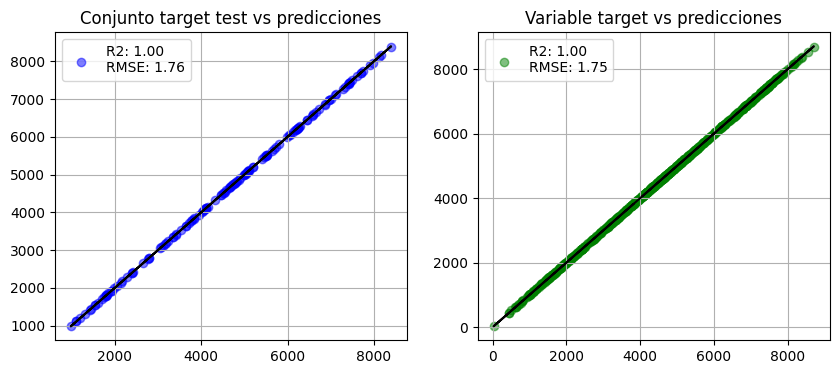

In [45]:
#------------------------------------------------------------------------
# Visualización comparativa de los datos de la variable target y predicha
#------------------------------------------------------------------------

x_test_plot = y_test.values
y_test_plot = y_test_pred.reshape(-1,1)

x_full_plot = y_data_full.values
y_full_plot = y_pred_full_poly.reshape(-1,1)

print('Test size = ', x_test_plot.shape)
print('Full data size =', x_full_plot.shape)

r2_test = round(r2_score(x_test_plot , y_test_plot),4)
rmse_test = np.sqrt(mean_squared_error(x_test_plot , y_test_plot, squared=False))
r2_full = round(r2_score(x_full_plot, y_full_plot),4)
rmse_full = np.sqrt(mean_squared_error(x_full_plot, y_full_plot, squared=False))

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x_test_plot , y_test_plot, c='blue', alpha=0.5, label=f'R2: {r2_test:.2f}\nRMSE: {rmse_test:.2f}')
ax[0].plot(x_test_plot,x_test_plot, color='black')
ax[0].set_title('Conjunto target test vs predicciones')
ax[0].grid(True)
ax[0].legend()

ax[1].scatter(x_full_plot,y_full_plot, c='green', alpha=0.5, label=f'R2: {r2_full:.2f}\nRMSE: {rmse_full:.2f}')
ax[1].plot(x_full_plot,x_full_plot, color='black')
ax[1].set_title('Variable target vs predicciones')
ax[1].grid(True)
ax[1].legend()

plt.show()

##### 3.2.2. Modelo lineal regularizado

---
Regresión Lasso

---

En esta subsección, para realizar el modelamiento de los datos, hemos seleccionado un modelo de regresión lineal regularizada por mecanísmo Lasso. A continuación, se realizan los siguientes procedimientos:

* Preprocesamiento de los datos:

  * División de los datos en variables independientes `X` y variables dependientes `y`.

  * Codificación ordinal. Ésto se hace para transformar los datos categóricos a numéricos ordinales. Hemos preferido adoptar un Ordinal Encoder en lugar de un OneHotEncoder ya que deseamos preservar el mísmo número de columnas en los datos de entrada para evitar un tiempo de entrenamiento más largo. Tambíen, hemos preferido este tipo de codificación para poder observar más adelante la importancia de las variables que conforman al conjunto de datos con respecto a la predicción del modelo, y no la importancia de las clases independientes.

  * División de los datos en los conjuntos de entrenamiento, validación y testeo.

  * Estandarización de los datos. Realizamos una estandarización de los datos de entrada `X` y `y` con base a los conjuntos de entrenamiento `X_train` y  `y_train` para asegurar una convergencia más rápida del algoritmo y una mayor presición en la predicción de la variable `y`. El objeto de estandarización, aprende los parámetros de la transformación a partir del conjunto de entrenamiento, luego, aplica ésta transformación a los conjuntos de valiración y prueba independientemente.

* Modelamiento de los datos por regresión lineal Lasso:
  * Creamos un regresor lineal regularizado mediante el mecanismo Lasso, el cuál, difiere de la regresión lineal simple en que en la función de costo, se adiciona un término correspondiente  a la suma del valor absoluto de los parámetros del modelo.

  * El entrenamiento del modelo se ejecuta mediante una técnica que combina `BaggingRegressor` la cuál es una función que ejecuta un entrenamiento del modelo en cuestión ejecutando primero un entrenamiento Bagging (Bootstrap Aggregating) la cuál es una técnica de conjunto que combina múltiples modelos independientes para reducir la varianza y mejorar la generalización del modelo, y una búsqueda de parámetros mediante `GridSearch`, la cuál es una técnica para encontrar los mejores hiperparámetros de un modelo, probando exhaustivamente diferentes combinaciones de valores predefinidos en una cuadrícula.

  * Finalmente, se aplica la transformación de estandarización inversa para retornar a los datos a su escala original.


No obstante, realizaremos dos evaluaciones de nuestro enfoque, en donde entrenaremos el modelo con datos estandarizados y luego con datos no estandarizados.

In [46]:
#-----------------------------------------
# Preprocesamiento de los datos de entrada
#-----------------------------------------

#----Division de los datos en las variables independientes X y la variable objetivo y---
X_data = data.drop(['cnt'], axis=1)
y_data = data[['cnt']]

#----Ordinal encoding----
data_processor = data_preprocessing()
X_encoded = data_processor.ordinal_encoder(X_data, inverse=False)

#----Data splitting----
train_size     = 0.6
val_test_size  = 0.4

X_train, X_dev  , y_train, y_dev  = data_processor.split( X_encoded, y_data, train_size, val_test_size )
X_val  , X_test , y_val  , y_test = data_processor.split( X_dev, y_dev, 0.5, 0.5 )

#----Data standarization----
X_train_scaled, y_train_scaled    = data_processor.data_scaling( X_train, y_train )
X_val_scaled  , y_val_scaled      = data_processor.data_scaling_transform( X_val, y_val )
X_test_scaled , y_test_scaled     = data_processor.data_scaling_transform( X_test, y_test )

#----------------------------------------------------------------------------------------
# Modelamiento de los datos por regresión lineal regularizada (para datos estandarizados)
#----------------------------------------------------------------------------------------

#----Regresor Lasso----
lasso_regression = Lasso()

#----Método de ensamble bagging----
bagg_lasso = BaggingRegressor(lasso_regression, random_state=77)
param_grid = {'n_estimators':[5,10,15,20],
              'max_samples' :[0.5,0.7,1.0],
              'estimator__alpha':[0.001, 0.01,0.1, 1, 2, 3, 4, 5]}

#----Entrenamiento del modelo por GridSearch con validación cruzada----
cantidad_de_folds = 10
kfold = KFold(n_splits=cantidad_de_folds, shuffle=True, random_state = 77)
grid  = GridSearchCV(bagg_lasso, param_grid, cv=kfold, scoring='neg_root_mean_squared_error')

grid.fit(X_train_scaled, y_train_scaled)

best_model  = grid.best_estimator_
best_params = grid.best_params_

y_train_pred = best_model.predict(X_train_scaled)
y_val_pred   = best_model.predict(X_val_scaled)
y_test_pred  = best_model.predict(X_test_scaled)

X_train_org, y_train_pred  = data_processor.inverse_scaling(X_train_scaled, y_train_pred.reshape(-1,1))
X_val_org  , y_val_pred    = data_processor.inverse_scaling(X_val_scaled, y_val_pred.reshape(-1,1))
X_test_org , y_test_pred   = data_processor.inverse_scaling(X_test_scaled, y_test_pred.reshape(-1,1))


#-------------------------------------------------------------------------------------------
# Modelamiento de los datos por regresión lineal regularizada (para datos NO estandarizados)
#-------------------------------------------------------------------------------------------

#----Regresor Lasso----
lasso_regression = Lasso()

#----Método de ensamble bagging----
bagg_lasso_nostd = BaggingRegressor(lasso_regression, random_state=77)
param_grid = {'n_estimators':[5,10,15,20],
              'max_samples' :[0.5,0.7,1.0],
              'estimator__alpha':[1, 2, 3, 4, 5]}

#----Entrenamiento del modelo por GridSearch con validación cruzada----
cantidad_de_folds = 10
kfold = KFold(n_splits=cantidad_de_folds, shuffle=True, random_state = 77)
grid_nostd  = GridSearchCV(bagg_lasso_nostd, param_grid, cv=kfold, scoring='neg_root_mean_squared_error')

grid_nostd.fit(X_train, y_train)

best_model_nostd  = grid_nostd.best_estimator_
best_params_nostd = grid_nostd.best_params_

y_train_pred_nostd = best_model_nostd.predict(X_train)
y_val_pred_nostd   = best_model_nostd.predict(X_val)
y_test_pred_nostd  = best_model_nostd.predict(X_test)

Una vez hemos entrenado nuestro modelo y seleccionado los mejores parámetros para el modelo Lasso concernientes a regularización, usaremos éstos mejores parámetros encontrados por una búsqueda exaustiva usando validación cruzada para re entrenar el modelo pero esta vez, sobre el conjunto de datos completo. Para esta labor, a continuación se realizan los siguientes procedimientos:

* Preprocesamiento de los datos:
  * Permutación aleatoria del conjunto de datos completo. Ésto se hace solo para prevenir un posible sobreajuste.

  * División de los datos en variables independientes `X` y variables dependientes `y`.

  * Codificación ordinal. Ésto se hace para transformar los datos categóricos a numéricos ordinales. Hemos preferido adoptar un Ordinal Encoder en lugar de un OneHotEncoder ya que deseamos preservar el mísmo número de columnas en los datos de entrada para evitar un tiempo de entrenamiento más largo. Tambíen, hemos preferido este tipo de codificación para poder observar más adelante la importancia de las variables que conforman al conjunto de datos con respecto a la predicción del modelo, y no la importancia de las clases independientes.

  * Estandarización de los datos. Realizamos una estandarización de los datos de entrada `X` y `y` para asegurar una convergencia más rápida del algoritmo y una mayor presición en la predicción de la variable `y`.

* Modelamiento de los datos por regresión polinomial:
  * Creamos un regresor lineal regularizado mediante el mecanismo Lasso, el cuál, difiere de la regresión lineal simple en que en la función de costo, se adiciona un término correspondiente  a la suma del valor absoluto de los parámetros del modelo.

  * El entrenamiento del modelo se ejecuta mediante una técnica de `BaggingRegressor` la cuál es una función que ejecuta un entrenamiento del modelo en cuestión ejecutando primero un entrenamiento Bagging (Bootstrap Aggregating) la cuál es una técnica de conjunto que combina múltiples modelos independientes para reducir la varianza y mejorar la generalización del modelo.

  * Finalmente, se aplica la transformación de estandarización inversa para retornar a los datos a su escala original.

In [47]:
#----Cambio aleatorio del orden de los regístros del dataset----
data_shuffled = data.sample(frac=1, random_state=13)

#----Division de los datos en las variables independientes X y la variable objetivo y---
X_data_full = data_shuffled.drop(['cnt'], axis=1)
y_data_full = data_shuffled[['cnt']]

#----Ordinal encoding----
data_processor = data_preprocessing()
X_encoded = data_processor.ordinal_encoder(X_data_full, inverse=False)
only_linear = Lasso(alpha=5)
only_linear.fit(X_encoded, y_data_full)
tester = only_linear.predict(X_encoded)

print(r2_score(y_data_full, tester))

0.9999999975871218


In [48]:
#-----------------------------------------
# Preprocesamiento de los datos de entrada
#-----------------------------------------

#----Cambio aleatorio del orden de los regístros del dataset----
data_shuffled = data.sample(frac=1, random_state=13)

#----Division de los datos en las variables independientes X y la variable objetivo y---
X_data_full = data_shuffled.drop(['cnt'], axis=1)
y_data_full = data_shuffled[['cnt']]

#----Ordinal encoding----
data_processor = data_preprocessing()
X_encoded = data_processor.ordinal_encoder(X_data_full, inverse=False)

#----Data standarization----
X_full_scaled, y_full_scaled = data_processor.data_scaling( X_encoded, y_data_full )


#----------------------------------------------------------------------------------------
# Modelamiento de los datos por regresión lineal regularizada (para datos estandarizados)
#----------------------------------------------------------------------------------------

#----Lasso regressor----
best_model_full = Lasso(alpha = best_params['estimator__alpha'])

#----Método de ensamble bagging----
bagg_model_full = BaggingRegressor(best_model_full,
                                   n_estimators = best_params['n_estimators'],
                                   max_samples  = best_params['max_samples'],
                                   random_state = 77
                                   )

#----Entrenamiento por ensamble----
bagg_model_full.fit(X_full_scaled, y_full_scaled)
best_bagg_model_full = min(bagg_model_full.estimators_, key=lambda model: mean_squared_error(y_test, model.predict(X_test)))
y_pred_full          = best_bagg_model_full.predict(X_full_scaled)

#----Escalamiento inverso de los datos----
X_full_lin , y_pred_full_lin   = data_processor.inverse_scaling(X_full_scaled, y_pred_full .reshape(-1,1))


#-------------------------------------------------------------------------------------------
# Modelamiento de los datos por regresión lineal regularizada (para datos NO estandarizados)
#-------------------------------------------------------------------------------------------

#----Lasso regressor----
best_model_full_nostd = Lasso(alpha = best_params_nostd['estimator__alpha'])

#----Método de ensamble bagging----
bagg_model_full_nostd = BaggingRegressor(best_model_full_nostd,
                                        n_estimators = best_params_nostd['n_estimators'],
                                        max_samples  = best_params_nostd['max_samples'],
                                        random_state = 77
                                        )

#----Entrenamiento por ensamble----
bagg_model_full_nostd.fit(X_encoded, y_data_full)
best_bagg_model_full_nostd = min(bagg_model_full_nostd.estimators_, key=lambda model: mean_squared_error(y_test, model.predict(X_test)))
y_pred_full_nostd          = best_bagg_model_full_nostd.predict(X_encoded)


In [49]:
# Mejor modelo encontrado por Grid Search
best_linear_model = best_bagg_model_full
best_linear_model

Lasso(alpha=0.001, random_state=609280367)

In [50]:
# Mejores parámetros
linear_best_params = best_params
linear_best_params

{'estimator__alpha': 0.001, 'max_samples': 1.0, 'n_estimators': 10}

In [51]:
# Mejor modelo encontrado por Grid Search para datos NO estandarizados
best_linear_model_nostd = best_bagg_model_full_nostd
best_linear_model_nostd

Lasso(alpha=1, random_state=1286325607)

In [52]:
# Mejores parámetros para datos NO estandarizados
linear_best_params_nostd = best_params_nostd
linear_best_params_nostd

{'estimator__alpha': 1, 'max_samples': 0.5, 'n_estimators': 5}

Para medir el desempeño del modelo y saber si se está incurriendo en alguna clase de sobre o sub ajuste, a continuación se calculan los siguientes puntajes según las métricas de RMSE, MAE y R2:

* Desempeño durante la selección de hiperparámetros:
  * Puntaje sobre el conjunto train.
  * Puntaje del mejor modelo en un paradigma de Cross Validation.
  * Puntaje del mejor modelo probeniente del GridSearch sobre el conjunto de validación.
  * Puntaje del mejor modelo probeniente del GridSearch sobre el conjunto de prueba.

* Desempeño durante el entrenamiento total:
 * Puntaje del mejor modelo sobre el conjunto total de datos.
 * Puntaje del mejor modelo sobre el conjunto total de datos en un paradigma de Cross Validation.

A continuación, se calculan las métricas de desempeño para el modelo Lasso entrenado con datos estandarizados.

In [53]:
#-----------------------------------------------------------------------------------------------------
# Validación de desempeño del modelo durante la selección de hiperparámetros para datos estandarizados
#-----------------------------------------------------------------------------------------------------

#----Rmse, Mae y R2----
y_data  = [y_train, y_val, y_test]
y_preds = [y_train_pred, y_val_pred, y_test_pred]

labels_rmse = ['Rmse Train', 'Rmse Validation', 'Rmse Test', 'Rmse CV', 'Rmse full model', 'Rmse CV full model']
labels_mae  = ['Mae Train', 'Mae Validation', 'Mae Test', 'Mae CV', 'Mae full model', 'Mae CV full model']
labels_r2   = ['R2 Train', 'R2 Validation', 'R2 Test', 'R2 CV', 'R2 full model', 'R2 CV full model']

rmse = [mean_squared_error(y_data[i], y_preds[i],squared=False) for i in range(len(y_preds))]
mae  = [mean_absolute_error(y_data[i], y_preds[i]) for i in range(len(y_preds))]
r2   = [r2_score(y_data[i], y_preds[i]) for i in range(len(y_preds))]

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores_hy     = cross_val_score(best_model, X_train_scaled, y_train_scaled, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer_hy     = make_scorer(r2_score)
cv_scores_r2_hy  = cross_val_score(best_model, X_train_scaled, y_train_scaled, cv=kfold, scoring=re_scorer_hy)
cv_scores_mae_hy = cross_val_score(best_model, X_train_scaled, y_train_scaled, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores_hy    = - cv_scores_hy
cv_rmse_mean_hy = cv_scores_hy.mean()
cv_mae_mean_hy  = cv_scores_mae_hy.mean()
cv_r2_mean_hy   = cv_scores_r2_hy.mean()

rmse.append(cv_rmse_mean_hy)
mae.append(cv_mae_mean_hy)
r2.append(cv_r2_mean_hy)

#---------------------------------------------------------------------------------------------------
# Validación de desempeño del modelo durante entrenamiento sobre todos los datos con estandarización
#---------------------------------------------------------------------------------------------------

#----Rmse y R2----
rmse.append( mean_squared_error(y_data_full, y_pred_full_lin, squared=False) )
mae.append( mean_absolute_error(y_data_full, y_pred_full_lin) )
r2.append( r2_score(y_data_full, y_pred_full_lin) )

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores = cross_val_score(best_bagg_model_full, X_encoded, y_data_full, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer = make_scorer(r2_score)
cv_scores_r2 = cross_val_score(best_bagg_model_full, X_encoded, y_data_full, cv=kfold, scoring=re_scorer)
cv_scores_mae = cross_val_score(best_bagg_model_full, X_encoded, y_data_full, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores    = - cv_scores
cv_rmse_mean = cv_scores.mean()
cv_mae_mean  = cv_scores_mae.mean()
cv_r2_mean   = cv_scores_r2.mean()

rmse.append(cv_rmse_mean)
mae.append(cv_mae_mean)
r2.append(cv_r2_mean)

#------------------------------
# Puntajes generales del modelo
#------------------------------
linear_stats = pd.DataFrame({'Rmse type' : labels_rmse,
                           'Rmse value': rmse,
                           'Mae type'  : labels_mae,
                           'Mae value' : mae,
                           'R2 type'   : labels_r2,
                           'R2 value'  : r2})

linear_stats

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,2.366053,Mae Train,1.920614,R2 Train,0.999998
1,Rmse Validation,2.237769,Mae Validation,1.834457,R2 Validation,0.999999
2,Rmse Test,2.386574,Mae Test,1.953857,R2 Test,0.999998
3,Rmse CV,0.001218,Mae CV,0.000992,R2 CV,0.999998
4,Rmse full model,2.120834,Mae full model,1.724276,R2 full model,0.999999
5,Rmse CV full model,0.151843,Mae CV full model,0.131308,R2 CV full model,1.000000


A continuación, se calculan las métricas de desempeño para el modelo Lasso entrenado sin estandarización.

In [54]:
#--------------------------------------------------------------------------------------------------------
# Validación de desempeño del modelo durante la selección de hiperparámetros para datos NO estandarizados
#--------------------------------------------------------------------------------------------------------

#----Rmse, Mae y R2----
y_data  = [y_train, y_val, y_test]
y_preds = [y_train_pred_nostd, y_val_pred_nostd, y_test_pred_nostd]

labels_rmse = ['Rmse Train', 'Rmse Validation', 'Rmse Test', 'Rmse CV', 'Rmse full model', 'Rmse CV full model']
labels_mae  = ['Mae Train', 'Mae Validation', 'Mae Test', 'Mae CV', 'Mae full model', 'Mae CV full model']
labels_r2   = ['R2 Train', 'R2 Validation', 'R2 Test', 'R2 CV', 'R2 full model', 'R2 CV full model']

rmse = [mean_squared_error(y_data[i], y_preds[i],squared=False) for i in range(len(y_preds))]
mae  = [mean_absolute_error(y_data[i], y_preds[i]) for i in range(len(y_preds))]
r2   = [r2_score(y_data[i], y_preds[i]) for i in range(len(y_preds))]

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores_hy     = cross_val_score(best_model_nostd, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer_hy     = make_scorer(r2_score)
cv_scores_r2_hy  = cross_val_score(best_model_nostd, X_train, y_train, cv=kfold, scoring=re_scorer_hy)
cv_scores_mae_hy = cross_val_score(best_model_nostd, X_train, y_train, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores_hy    = - cv_scores_hy
cv_rmse_mean_hy = cv_scores_hy.mean()
cv_mae_mean_hy  = cv_scores_mae_hy.mean()
cv_r2_mean_hy   = cv_scores_r2_hy.mean()

rmse.append(cv_rmse_mean_hy)
mae.append(cv_mae_mean_hy)
r2.append(cv_r2_mean_hy)

#---------------------------------------------------------------------------------------------------
# Validación de desempeño del modelo durante entrenamiento sobre todos los datos SIN estandarización
#---------------------------------------------------------------------------------------------------

#----Rmse y R2----
rmse.append( mean_squared_error(y_data_full, y_pred_full_nostd, squared=False) )
mae.append( mean_absolute_error(y_data_full, y_pred_full_nostd) )
r2.append( r2_score(y_data_full, y_pred_full_nostd) )

#----puntaje por validación cruzada----
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
cv_scores = cross_val_score(best_bagg_model_full_nostd, X_encoded, y_data_full, cv=kfold, scoring='neg_root_mean_squared_error')
re_scorer = make_scorer(r2_score)
cv_scores_r2 = cross_val_score(best_bagg_model_full_nostd, X_encoded, y_data_full, cv=kfold, scoring=re_scorer)
cv_scores_mae = cross_val_score(best_bagg_model_full_nostd, X_encoded, y_data_full, cv=kfold, scoring=make_scorer(mean_absolute_error))

cv_scores    = - cv_scores
cv_rmse_mean = cv_scores.mean()
cv_mae_mean  = cv_scores_mae.mean()
cv_r2_mean   = cv_scores_r2.mean()

rmse.append(cv_rmse_mean)
mae.append(cv_mae_mean)
r2.append(cv_r2_mean)

#------------------------------
# Puntajes generales del modelo
#------------------------------
linear_stats_nostd = pd.DataFrame({'Rmse type' : labels_rmse,
                                   'Rmse value': rmse,
                                   'Mae type'  : labels_mae,
                                   'Mae value' : mae,
                                   'R2 type'   : labels_r2,
                                   'R2 value'  : r2})

linear_stats_nostd

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,0.092652,Mae Train,0.077272,R2 Train,1.0
1,Rmse Validation,0.095283,Mae Validation,0.079391,R2 Validation,1.0
2,Rmse Test,0.089228,Mae Test,0.074188,R2 Test,1.0
3,Rmse CV,0.071446,Mae CV,0.060257,R2 CV,1.0
4,Rmse full model,0.074232,Mae full model,0.062583,R2 full model,1.0
5,Rmse CV full model,0.107442,Mae CV full model,0.089230,R2 CV full model,1.0


Para hacernos una idea visual de la calidad de las predicciones de nuestro modelo, graficamos en el eje X los valores reales del conjunto target de prueba y del conjunto de datos en total, mientras que en el eje y, destinamos los valores predichos para la variable target en el conjunto de prueba y en el conjunto de datos total. A continuación, se grafican los resultados obtenidos para el modelo estandarizado.

Test size =  (147, 1)
Full data size = (731, 1)


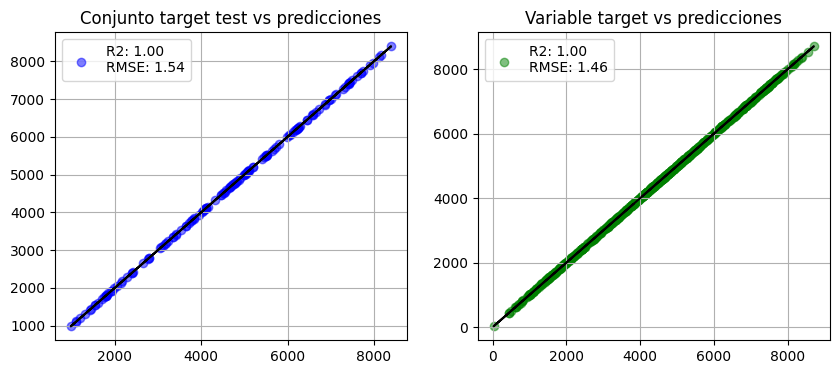

In [55]:
#------------------------------------------------------------------------
# Visualización comparativa de los datos de la variable target y predicha
#------------------------------------------------------------------------

x_test_plot = y_test.values
y_test_plot = y_test_pred.reshape(-1,1)

x_full_plot = y_data_full.values
y_full_plot = y_pred_full_lin.reshape(-1,1)

print('Test size = ', x_test_plot.shape)
print('Full data size =', x_full_plot.shape)

r2_test = round(r2_score(x_test_plot , y_test_plot),4)
rmse_test = np.sqrt(mean_squared_error(x_test_plot , y_test_plot, squared=False))
r2_full = round(r2_score(x_full_plot, y_full_plot),4)
rmse_full = np.sqrt(mean_squared_error(x_full_plot, y_full_plot, squared=False))

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x_test_plot , y_test_plot, c='blue', alpha=0.5, label=f'R2: {r2_test:.2f}\nRMSE: {rmse_test:.2f}')
ax[0].plot(x_test_plot,x_test_plot, color='black')
ax[0].set_title('Conjunto target test vs predicciones')
ax[0].grid(True)
ax[0].legend()

ax[1].scatter(x_full_plot,y_full_plot, c='green', alpha=0.5, label=f'R2: {r2_full:.2f}\nRMSE: {rmse_full:.2f}')
ax[1].plot(x_full_plot,x_full_plot, color='black')
ax[1].set_title('Variable target vs predicciones')
ax[1].grid(True)
ax[1].legend()

plt.show()

# **4. Análisis comparativo de modelos**

----
Análisis comparativo de modelos

---

La presente sección está destinada a analizar los resultados obtenidos en el presente proyecto ofreciendo una comparación entre los dos modelos seleccionados para modelar los datos de nuestro problema. Aquí, procederemos a analizar las métricas de desempeño así como la importancia de cada variable dentro del dataset según el modelo Lasso. En general, aquí se pretende responder a las siguientes preguntas:

* **Pregunta 1:**¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?

* **Pregunta 2:**¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?

* **Pregunta 3:**A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?

* **Pregunta 4:**¿Cuáles variables fueron seleccionadas con el modelo Lasso? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

Para responder la **Pregunta 1**, hemos empleado una técnica de validación cruzada y búsqueda de hiperparámetros por medio de la técnica GridSearch, donde el grado del polinomio que mejor desempeño tuvo fue `degree = 3`. Ya que nuestro modelo polinomial fue planteado como una regresión polinomial, el parámetro de regresión que mejor desempeño tuvo fue `alpha = 0.01`.

In [56]:
poly_best_params

{'lasso__alpha': 0.001, 'polynomialfeatures__degree': 2}

En el caso de la regresión Lasso, los lineamientos del presente proyecto dictaban que el parámetro de regularización fuese uno de los siguientes valores `alpha = [1,2,3,4,5]`. No obstante, éste modelo presenta la particularidad de que si una estandarización de los datos de entrada es efectuada, el modelo Lasso no tendrá buen desempeño si el parámetro de regularización es mayor a uno, produciendo resultados con precisión nula. En caso contrario, si ninguna estandarización es efectuada, el modelo Lasso si puede explicar cierto porcentaje de los datos.

Sin embargo, bien sea que se emplee un modelo con estandarización o sin estandarización, la regresión Lasso siempre prefiere usar el parámetro `alpha` con el menor valor posible. Por ejemplo, si se emplea una estandarización de los datos, la regularización óptima es para el valor `alpha = 0.001`, mientras que el modelo Lasso sin estandarización se tiene  `alpha = 1`.

después de realizar muchos entrenamientos con éstos valores el modelo lineal Lasso no fue capaz de explicar el patrón de los datos en nuestra variable de interés, la frecuencia de alquiler. Los resultados fueron sumamente pobres y la precisión del modelo fué casi nula.

En general, los modelos con los modelos Lasso fue posible hacer del modelo lo suficientemente flexible para que explicara aproximadamente el 40% de la variabilidad de los datos. La explicación concerniente a la preferencia del modelo Lasso hacia valores de `alpha` pequeños, se debe a que el modelo lineal al ser un modelo tan simple, al verse regularizado fuertemente inhibe aún más su capacidad para adaptarse a los datos ya que la regularizción es un proceso de "hacer énfasis" en el uso de parámetros pequeños para el modelo. Así, si los parámetros son forzados a tener valores pequeños. En este sentido, el modelo es más propenso a errar  y dentro del contexto del modelo lineal, el hecho que los parámetros sean forzados a ser cercanos a cero, el modelo representa un hiperplano que no posee "inclinación" alguna, siendo ésta "inclinación" la forma en la que el modelo se ajusta a  los datos. Es decir, inhibir la "inclinación" del hiperplano es equivalente a no permitir que el modelo se ajuste a los datos.

Note además que si `alpha` es mayor a uno, se está amplificando el valor del error que el modelo naturalmente posee, así, un valor de `alpha` mayor a uno generará un modelo con una cantidad de error considerable.



In [57]:
linear_best_params

{'estimator__alpha': 0.001, 'max_samples': 1.0, 'n_estimators': 10}

In [58]:
linear_best_params_nostd

{'estimator__alpha': 1, 'max_samples': 0.5, 'n_estimators': 5}

Para responder a la **Pregunta 3**, a continuación se presentan las tablas comparativas para cada modelo usado en el proyecto, donde se han calculado el valor de RMA, MAE y R2.

Éstos resultados ilustran que ninguno de los modelos es lo suficientemente adecuado para modelar los datos ya que en general, solo el `40%` de la variabilidad de los datos es explicada por los modelos lineales, y el `48%` en el caso del modelo polinomial. Más aún, según el MAE y el RMSE, para los modelos lineales se tiene que en promedio el error de la predicción se encuentra entre `98 y 137 alquileres`. Es decir, el error  promedio para las predicciones de la cantidad de alquileres de bicicletas por clientes se encuentra ente 100 y 137, un error bastante considerable ya que estos valores se encuentran dentro de la escala  de los datos y teniendo en cuenta que la frecuencia/cantidad de alquileres por cliente promedio es igual a `182`.

Aún así, si observamos las métricas de desempeño para los conjuntos de test, para el desempeño del modelo sobre el conjunto completo de datos, y los valores obtenidos para las validaciones cruzadas tanto en la búsqueda de hiperparámetros como en la evaluación cruzada del modelo sobre el conjunto completo de datos, la jerarquía de eficiencia de mayor a menor para nuestros modelos es:

1. Modelo polinomial
2. Modelo Lasso con estandarización
3. Modelo Lasso sin estandarización

In [59]:
linear_stats

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,2.366053,Mae Train,1.920614,R2 Train,0.999998
1,Rmse Validation,2.237769,Mae Validation,1.834457,R2 Validation,0.999999
2,Rmse Test,2.386574,Mae Test,1.953857,R2 Test,0.999998
3,Rmse CV,0.001218,Mae CV,0.000992,R2 CV,0.999998
4,Rmse full model,2.120834,Mae full model,1.724276,R2 full model,0.999999
5,Rmse CV full model,0.151843,Mae CV full model,0.131308,R2 CV full model,1.000000


In [60]:
linear_stats_nostd

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,0.092652,Mae Train,0.077272,R2 Train,1.0
1,Rmse Validation,0.095283,Mae Validation,0.079391,R2 Validation,1.0
2,Rmse Test,0.089228,Mae Test,0.074188,R2 Test,1.0
3,Rmse CV,0.071446,Mae CV,0.060257,R2 CV,1.0
4,Rmse full model,0.074232,Mae full model,0.062583,R2 full model,1.0
5,Rmse CV full model,0.107442,Mae CV full model,0.089230,R2 CV full model,1.0


In [61]:
poly_stats

,Rmse type,Rmse value,Mae type,Mae value,R2 type,R2 value
0,Rmse Train,3.062470,Mae Train,2.496838,R2 Train,0.999997
1,Rmse Validation,3.006027,Mae Validation,2.460079,R2 Validation,0.999998
2,Rmse Test,3.082787,Mae Test,2.551620,R2 Test,0.999997
3,Rmse CV,44.028158,Mae CV,21.726434,R2 CV,0.999236
4,Rmse full model,3.072891,Mae full model,2.513813,R2 full model,0.999997
5,Rmse CV full model,20.268860,Mae CV full model,12.953893,R2 CV full model,0.999878


Para abordar la **Pregunta 5**, implementamos la técnica de Eliminación Recursiva de Características (RFE, por sus siglas en inglés), que es un método de selección de características. Esta técnica busca identificar el subconjunto óptimo de características, eliminando progresivamente las menos significativas y reajustando el modelo en cada paso, para así establecer una jerarquía de importancia basada en la contribución de cada característica. Posteriormente, examinamos los valores resultantes para los parámetros del modelo Lasso estandarizado.

In [62]:
lasso_model = Lasso(alpha=0.1)

lasso_model = best_linear_model
selector = RFE(estimator=lasso_model, n_features_to_select=3, step=1)
selector = selector.fit(X_full_scaled, y_full_scaled)

selected_features = selector.support_
feature_ranking = selector.ranking_

df_ranking = pd.DataFrame({'Característica': X_encoded.columns,
                            'Ranking': feature_ranking})
df_ranking_sorted = df_ranking.sort_values(by='Ranking')

print("Tabla de Ranking de Características:")
df_ranking_sorted

Tabla de Ranking de Características:


,Característica,Ranking
12,casual,1
13,registered,1
14,dteday,1
11,windspeed,2
10,hum,3
9,atemp,4
8,temp,5
7,weathersit,6
6,workingday,7
5,weekday,8


In [63]:
lasso_model = Lasso(alpha=0.1)

lasso_model = best_linear_model_nostd
selector = RFE(estimator=lasso_model, n_features_to_select=3, step=1)
selector = selector.fit(X_full_scaled, y_full_scaled)

selected_features = selector.support_
feature_ranking = selector.ranking_

df_ranking = pd.DataFrame({'Característica': X_encoded.columns,
                            'Ranking': feature_ranking})
df_ranking_sorted = df_ranking.sort_values(by='Ranking')

print("Tabla de Ranking de Características:")
df_ranking_sorted

Tabla de Ranking de Características:


,Característica,Ranking
12,casual,1
13,registered,1
14,dteday,1
11,windspeed,2
10,hum,3
9,atemp,4
8,temp,5
7,weathersit,6
6,workingday,7
5,weekday,8


In [64]:
relevancia_caracteristicas = pd.DataFrame({'Variable':X_encoded.columns, 'Relevancia':best_linear_model.coef_})
relevancia_caracteristicas['Relevancia'] = relevancia_caracteristicas['Relevancia'].abs()
relevancia_caracteristicas.sort_values(by='Relevancia', ascending=False)

,Variable,Relevancia
13,registered,0.804783
12,casual,0.353758
0,instant,0.000000
1,season,0.000000
2,yr,0.000000
3,mnth,0.000000
4,holiday,0.000000
5,weekday,0.000000
6,workingday,0.000000
7,weathersit,0.000000


In [65]:
relevancia_caracteristicas = pd.DataFrame({'Variable':X_encoded.columns, 'Relevancia':best_linear_model_nostd.coef_})
relevancia_caracteristicas['Relevancia'] = relevancia_caracteristicas['Relevancia'].abs()
relevancia_caracteristicas.sort_values(by='Relevancia', ascending=False)

,Variable,Relevancia
0,instant,5.781078
14,dteday,5.780851
12,casual,1.000075
13,registered,0.999939
1,season,0.000000
2,yr,0.000000
3,mnth,0.000000
4,holiday,0.000000
5,weekday,0.000000
6,workingday,0.000000


Al examinar los resultados jerárquicos previos, se constata que aunque los modelos lineales presentan niveles parecidos de precisión o rendimiento, cada uno aporta una visión distinta sobre la interpretación del problema. Por ejemplo, al estandarizar los datos, el modelo Lasso revela que los cuatro factores clave en la determinación del número de alquileres de bicicletas son, en orden, `"momento del día, sensación térmica, humedad y temperatura"`. En contraste, el modelo Lasso sin estandarizar indica que las cuatro variables más relevantes son `"humedad, momento del día, temporada y sensación térmica"`.

Aunque las interpretaciones de ambos modelos son muy parecidas, existen pequeñas diferencias. Sin embargo, al analizar en profundidad, se deduce que la probabilidad de alquiler de bicicletas está influenciada por el flujo de personas en la ciudad, lo cual a su vez depende del momento del día por los horarios laborales y de actividad, y por las condiciones climáticas. Además, no es ilógico considerar que la "calidad del clima" sea una variable menos crucial para el modelo, dado que esta depende de factores más fundamentales como la temperatura y la humedad, y por ende, de la temporada.

Por lo tanto, si aceptamos que el "factor humano" y las "condiciones meteorológicas" son los principales determinantes en la cantidad de alquileres, las variables relacionadas a estos factores son `"humedad, momento del día, temporada y sensación térmica"`. Así, el modelo Lasso no regularizado se perfila como el que proporciona la interpretación más acertada del problema, ya que este incluye en sus cuatro variables principales a la temperatura, excluyendo una variable tan significativa como la temporada del año.

En conclusión, dentro del contexto del problema, el modelo Lasso no estandarizado emerge como el más adecuado para comprender el origen de la variación en el número de alquileres de bicicletas, reconociendo que factores humanos como el momento del día y meteorológicos como la humedad, la temporada y la sensación térmica, son las variables más influyentes en el alquiler de bicicletas.